# ULMFiT approach

## What's the problem?

We're given labeled data (curated from Kaggle) regarding airline sentiment. More specifically, our input data is a collection of tweets, and each tweet has an associated label of 'positive', 'neutral', or 'negative'. Our goal is to predict the sentiment of a tweet based on the text we're given (we'll get more into the details of the dataset later)

Given that the problem supervised (we have labels, and we're trying to learn them), we could resort to typical machine learning/deep learning approaches for text classification, as we would do with any supervised machine learning problem. 

**The main issue is that with Twitter Airline Sentiment, and various other text classification problems, we don't have much data. Collecting data and labeling it is cumbersome, and it's difficult to leverage the power of deep learning if we don't have a large amount of data to work with.**

## What's the solution?

## Transfer Learning

Transfer learning has been used successfully in computer vision for some time now. Transfer learning is helpful because we can put all our time and resources into training one model on a large set of data, and then reuse weights/layers/architectures from that model on similar tasks.

We've tried to use transfer learning in NLP with **word embeddings**. Algorithms that learn word embeddings typically use something called an **embedding layer**, or an **embedding matrix**. According to Jeremy Howard and Sebastian Ruder (authors of ULMFiT), however, using a single neural layer isn't using the power of neural networks to their fullest because  of the numerous hidden layers that they usually contain.

So what's the equivalent of transfer learning NLP? And how do we use more than just a single neural layer to do transfer learning?


## Language modeling

This is where **RNN language models** come in. Language modeling is helpful because
- The neural network is given the task of predicting the next word in a sentence, which requires the network to learn more nuanced, sophisticated features of language.
- Language modeling is an unsupervised task that has an infinitely large corpus of data to work with: we don't have to collect customized labels.

According to Howard/Ruder, while this has been tried before, it wasn't done as smartly as it could have been done.  The ULMFiT model is as follows (don't worry, we'll get into the details later to see exactly how this works):
1. Pretrain an effective language model on a large text corpus.
2. Fine-tune the language model to the text data from the relevant classification task
3. Fine-tune the classifier for the relevant task.

To summarize, the great things about ULMFiT are:
- We don't have to collect a **large** amount of labeled data for a particular classification task.
- We only have to train a language model once. After that, all the steps are fine-tuning steps that are computationally inexpensive.
- We can use the power of **RNN language models**, which learn important features of language like **syntax** and **semantics**. 

## Pretrain the language model

The first part of the ULMFiT approach is training a language model on a large corpus of text data. If we (more specifically, I) had more computational resources, we could train a language model like GPT-2 (OpenAI) that has produced state-of-the-art results. However, Jeremy Howard has created the fastai PyTorch library that makes the **AWD-LSTM language model** fully available. It's also pretrained on the Wikitext 103 dataset, so we don't have to use any time/resources to pretrain a language model ourselves. 

The AWD-LSTM, created by Stephen Merity, has also produced great results that are detailed in his paper "Regularizing and Optimizing LSTM Language Models." The purported reasons for the language model's effectiveness are:
- Use of an LSTM architecture, which does a great job of learning **long-term dependencies** in sentences.
- Use of various **dropouts**, which aims to solve the problem of **overfitting** in RNN language models. 
- Other advanced techniques, such as **variable-length backpropagation sequences** (makes the most efficient use of the data we're given), **temporal activation regularization** (placing L2 regularization on the hidden activations to prevent substantial changes in hidden state), etc.


## Importing the Twitter data

In [1]:
# allow us to import data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# make our root and base directories clear
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Fellowship-ai-challenge/'

import pandas as pd
df = pd.read_csv(base_dir + 'Tweets.csv')

## Exploratory data analysis - Twitter Airline Sentiment

Before we start fine-tuning our model, let's do some exploratory data analysis to understand what our data looks like.

Note that EDA won't have much of an impact on how we go about fine-tuning our model, but it'll give us some more insight, and perhaps allow us to make some more educated conclusions later.

In [3]:
# this is what the data looks like
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
# what does the distribution look like for 

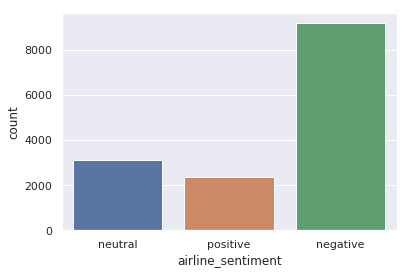

In [5]:
# what does the distribution look like for the various sentiments?
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(x="airline_sentiment", data=df)

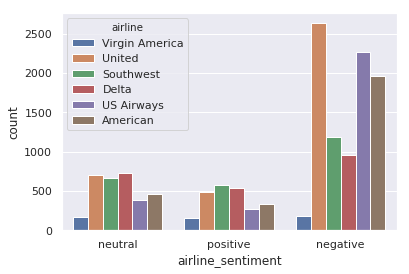

In [6]:
# what does sentiment distribution look like for various airlines?
ax = sns.countplot(x="airline_sentiment",hue='airline', data=df)

[Text(0, 0, 'Bad Flight'),
 Text(0, 0, "Can't Tell"),
 Text(0, 0, 'Late Flight'),
 Text(0, 0, 'Customer Service Issue'),
 Text(0, 0, 'Flight Booking Problems'),
 Text(0, 0, 'Lost Luggage'),
 Text(0, 0, 'Flight Attendant Complaints'),
 Text(0, 0, 'Cancelled Flight'),
 Text(0, 0, 'Damaged Luggage'),
 Text(0, 0, 'longlines')]

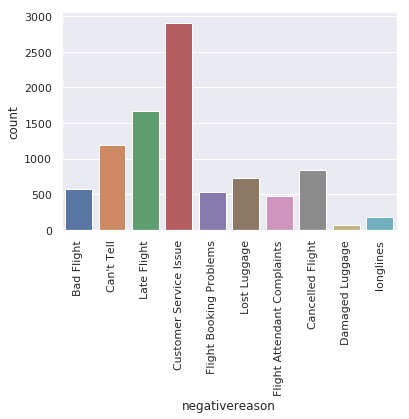

In [7]:
# what's the distribution look like for the negative reason?
ax = sns.countplot(x='negativereason',data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Some takeaways from EDA:
- There are a lot more negative tweets than positive and neutral ones. 
- United has the most negative tweets amongst the different airlines
- The most common reason for a negative Tweet was a customer service issue.

# Fine-tune the language model to the target dataset

Now, we need to tune the pretrained language model to the particular dataset. In this case, that's the Twitter US Airline Sentiment dataset from Kaggle. 

Before actually fine-tuning the model, it would be helpful to do some **domain-specific preprocessing** so that our language model can extract the best signal from the text that it's given. For example, with a Twitter dataset, there are often extraneous characters like '#' and '@' which **may** detract from the signal to predict the next word of a particular phrase/sentence. This isn't for certain, as characters like hashtags **could** provide a better signal for predicting  the next word, as well as the sentiment. These formulations are somewhat abstract, and experimentation is the best way to gain more insight. **Remember, the better our fine-tuned language model, the better our results will be.** So what's the best way to preprocess our twitter data? 

### Preprocessing the Twitter data

Luckily, others have already investigated Twitter preprocessing techniques for us! In fact, there's been research conducted to determine what techniques in Tweet preprocessing have lead to better results in sentiment analysis: Dimotrios Effrosynidis wrote a paper called "A Comparison of Pre-processing Techniques for Twitter Sentiment Analysis. And the best part is that he open sourced his code for us to use.

**It's completely okay for us to reuse other people's work in order to produce the best results that we can, as long as we properly cite their work.**

Let's define some functions to preprocess the text data. The decisions in which to preprocess were based on intuitions (for example, our assumption is that removing a hashtag would reduce noise and improve signal), as well as research paper results (removing numbers, replacing urls, and replacing user mentions were shown to improve accuracy on Twitter Sentiment Analysis).

In [0]:
import re

def removeUnicode(text):
  """ Removes unicode strings like "\u002c" and "x96" """
  text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
  text = re.sub(r'[^\x00-\x7f]',r'',text)
  return text
  
def replaceURL(text):
  """Replaces url address with "url" """
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
  text = re.sub(r'#([^\s]+)', r'\1', text)
  return text

def replaceAtUser(text):
  """ Replaces "@user" with "atUser" """
  # text = re.sub('@[^\s]+','atUser',text)
  text = re.sub('@[^\s]+','',text)
  return text

def removeHashtagInFrontOfWord(text):
  """ Removes hastag in front of a word """
  text = re.sub(r'#([^\s]+)', r'\1', text)
  return text

def removeNumbers(text):
  """ Removes integers """
  text = ''.join([i for i in text if not i.isdigit()])         
  return text

def removeEmoticons(text):
  """ Removes emoticons from text """
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
  return text


""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
  patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
  for (pattern, repl) in patterns:
      (text, count) = re.subn(pattern, repl, text)
  return text

Now, we'll preprocess our dataframe, split it into training and testing sets, and export it to csv's which we can later import in order to fine-tune our language model.

In [0]:
def preprocessTwitterData(df):
  """Function to apply text preprocessing functions to a dataframe"""
  
  # remove unicode
  df['text'] = df['text'].apply(removeUnicode)
  
  # replace url
  df['text'] = df['text'].apply(replaceURL)
  
  # replace '@' signs
  df['text'] = df['text'].apply(replaceAtUser)
  
  
  # replace hastags
  df['text'] = df['text'].apply(removeHashtagInFrontOfWord)
  
  # remove numbers in the tweets
  df['text'] = df['text'].apply(removeNumbers)
  
  # remove the emoticons
  df['text'] = df['text'].apply(removeEmoticons)
  
  # replace contractions
  df['text'] = df['text'].apply(replaceContraction)
  
# Call the function and preprocess the data  
preprocessTwitterData(df)

# Since we don't need the rest of the columns in the data, subindex the
# relevant columns and make this the new dataframe
df = df[['text','airline_sentiment']]

# Split the dataset into a train and test set.
# Using a validation set is built into the fastai
# API, so we don't need to do this split ourselves

# use an 80-20 split for the train and test sets
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.1,random_state=20)

# Convert the cleaned training and testing data
# into their own CSV files which we can import
# later to perform modeling on them

# these lines write CSV files to our current directory
df_train.to_csv('twitter_data_cleaned_train.csv')
df_test.to_csv('twitter_data_cleaned_test.csv')


## Converting the dataset to the appropriate form

Now that we've preprocessed the data and split it into a training and a testing set, we need to get our data in a form that fastai can work with.

In particular, the fastai operates with a class called a DataBunch, which is an efficient, convenient way of tying in the processes of data loading, data batchifying, and data transforming. Jeremy Howard (author of fastai) then creates custom classes that inherit from the DataBunch that can customize these processes for different deep learning tasks, such as vision, text, tabular data, etc. Howard goes through the from-scratch implementations in his fast.ai course, so definitely check that out for more detail (DataBunch can actually do more than we're describing here).

In this case, we'll be using the "TextLMDataBunch" class to wrap our Twitter data and get it ready to put into our pretrained language model:

In [10]:
# import everything from the fastai.text lib
from fastai.text import *

# create a 'TextLMDataBunch' from a csv file.
# We specify 'valid=0.1' to signify that when we want to
# actually put this into our language model, we'll be setting
# off 10% of it for a validation set
data_lm = TextLMDataBunch.from_csv(path='',csv_name='twitter_data_cleaned_train.csv',valid_pct=0.1)

# run this to see how the batch looks like
data_lm.show_batch()

idx,text
0,"not heard back and i 'm flying this week disappointed xxbos xxmaj could not use the confirmed upgd cert you gave me b / c you decided to sell anyone a biz seat for $ . xxmaj why do you bother giving them ? xxbos xxmaj for my xxmaj grandma xxmaj ella is th , she would love a birthday greeting from your flight crew ! xxmaj she was a"
1,"going to some other city and getting to xxup ny sometime on xxmaj we d ? ! i 'm sorry that is not gon na cut xxbos trying to get through to cust relations . xxmaj is there another # to use ? xxbos thanks ! xxbos xxmaj love your airline ... hate your website . xxmaj just tried to book tickets ( w miles , w / out )"
2,"cleveland xxmaj xxunk xxmaj airport . xxmaj please xxmaj help xxbos i understand delays . xxmaj we are all looking at a tv monitor at ur gate and it says current conditions are snow , hence delay . xxbos xxmaj how is it possible that your call system can refuse callers for over twelve hours ? xxmaj what service options does that leave ? xxbos free hotel does not make"
3,could you please help ? xxbos how can i check to see if my flight to xxup nyc is expected to be delayed or xxmaj cancelled xxmaj flightled for this xxmaj tuesday ? xxbos i left an item on the plane and have been calling non stop and no one has been answering can you please help xxbos need to learn operations . xxmaj sit a plane overnight at gsp
4,first ! xxbos xxmaj got flight reschedule to flight form xxup pit to xxup fll and our flight had mechanical problems so we were delayed an hour xxmaj missed my connect xxbos would love help getting there today . xxmaj in xxup ewr now . xxmaj will take any airline and connections . xxmaj thx xxbos xxmaj how is xxmaj dallas incoming looking ? i 'm scheduled to fly in


This is what a "batch" looks like from our 'TextLMDataBunch' object. We can see that there are tags within the text such as 'xxbos' and 'xxunk'. These are tokens that are included in the vocabulary of the language model ('xxbos' signifies the beginning of a sentence, for example), and so they capture information that may assist in the effectiveness of the language model itself.

There are other advanced tokenization techniques that are implemented in the fastai library, we won't discuss them in detail here. Details can be found at the source code for fastai.

Now we'll pass our Twitter data into something called the 'language_model_learner' class, which inherits from the 'learner' class in fastai. This is fastai's way of training models: it takes in **callback** functions that can "call" back to to other parts of the fastai library, such as specific training techniques (gradient clipping, discriminative learning rates, etc.). 

**Using this language_model_learner class is key to applying some of the novel techniques that the ULMFiT paper proposes.**

In [0]:
# pass in our 'data_lm' objet to specify our Twitter data
# pass in AWD_LSTM to specify that we're using this particular
# language model
# pass in drop_mult=0.4 to specify that our dropouts for the model
# are with p = 0.3
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

What happened when we ran this line of code? Let's see how our model looks like now.

In [12]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(5232, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(5232, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5232, bias=True)
    (output_dp): RNNDropout()
  )
)

Most of this should look familiar if you're familiar with the AWD-LSTM. To review:

- **Embedding dropout** randomly takes out certain embedding vectors
- **Weight dropout** randomly drops out weights of the hidden-to-hidden states in the LSTM
- **RNN Dropout** refers to the **variational dropout** that is applies the same dropout mask to every input to a LSTM cell (this can refer to the inputs in the actual input sequence, or the output from a LSTM cell to another LSTM cell)

There's a Linear decoder (an embedding layer), 3 LSTM layers, and a linear decoder that maps the last hidden state to a softmax layer with all the vocab words. **The weights between the linear encoder and linear decoder (embedding layer and softmax layer) are tied.**

More details, of course, can be found in Stephen Merity's paper.

The one part that has changed is the actual embedding matrix itself. With the language model trained on Wikitext 103, there was a vocab size of over 200,000. Now, the vocab size has adjusted to a much lower size. What happened here?

Obviously, words that are not in the Twitter dataset are deleted, as they have no use. As for words that are in the Twitter dataset but not the Wiki dataset, **they're assigned the mean across all the rows of the Wikitext embeddings.**

## Optimal learning rate finding

Now we can start fine-tuning the model with some of the techniques outlined by Jeremy Howard and Sebastien Ruder. 

First we use the fastai learning rate finder to find an **optimal learning rate** given our dataset. 

The idea behind this is that we start with a really low learning rate, and use it to train our language model. We then record the loss, and repeat the process with increasingly high learning rates. If we plot the loss against the learning rate, we will see that there's a point where the loss starts to increase rapidly:

In [13]:
# fastai learning-rate finding
# implemented using fastai callbacks
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


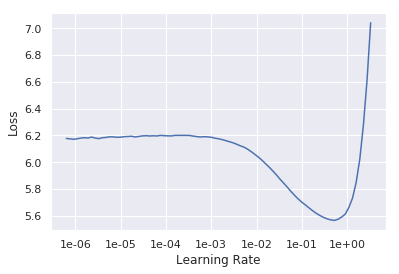

In [14]:
# plot the graph we were talking about earlier
learn.recorder.plot()

 The fact that the loss starts to increase rapidly makes sense at a certain point makes sense: **if we perform gradient descent steps that are too large, we will overshoot the minima on the cost function.** 

According to [this](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html) article by Sylvain Gugger of fast.ai, it's better to pick a learning rate that isn't at the minimum, but just before the minimum. This makes sense as well, since picking the learning rate at the minimum is likely to already be too high (it's just before the loss starts to move out of control).

Looking at our graph, it makes sense to pick something slightly smaller than 6e-1.

## The 1cycle policy

But what's the point of finding this learning rate? Howard and Ruder have adopted an advanced technique from Leslie Smith's paper "A Disciplined Approach to Neural Network Hyper-parameters: Part 1 - Learning Rate, Batch Size, Momentum, and Weight Decay" called the **1cycle policy**. 

The 1cycle policy needs **maximum learning rate**, which we gradually approach throughout the learning process by starting at a learning rate of (max_learning_rate/dividing_factor), and then multiplying by some factor until we get to max_learning_rate. Once we get there, we gradually decrease the learning rate until we get back to max_learning_rate/dividing_factor. The approach is the same with a minimum and maximum momentum, except we essentially do the opposite. Look at the image below to see a graphical representation:

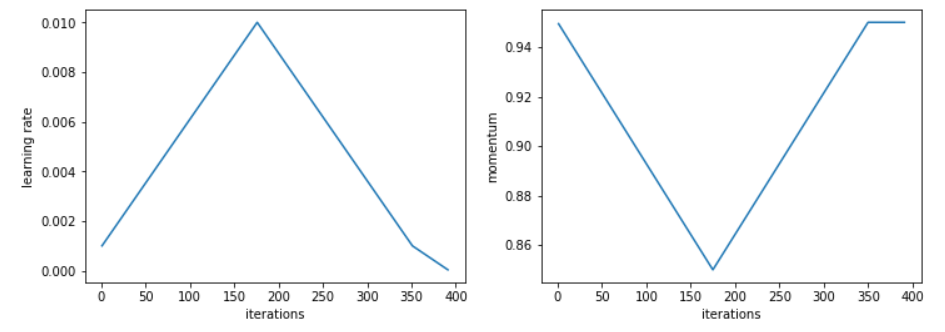

In [15]:
from IPython.display import Image
Image(base_dir + 'onecycle_params.png')

This optimization technique has theoretical grounds, but we won't get into the details of that here. **The most important thing, for our purposes, is that the approach tends to get us the best results with ULMFiT.**

## Slanted triangular learning rates

In practice, Howard/Ruder use a slight modification of the 1cycle policy called **slanted triangular learning rates**. The approach is very similar to that of the 1cycle policy, except that the learning rate increases rapidly at the beginning of the training process, and then decays slowly once it hits the maximum. Look at the image below:

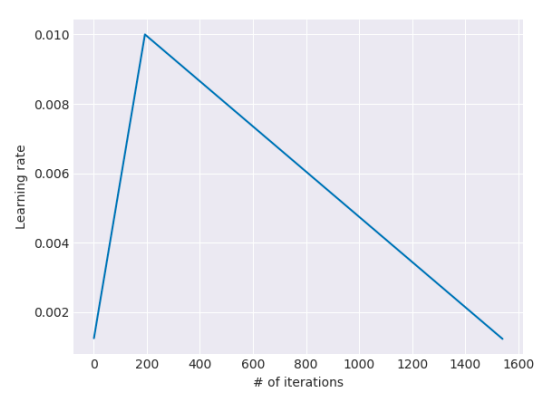

In [16]:
Image(base_dir+'slanted-triangular-lr.png')

fastai provides us with an easy way of using this custom optimization technique with the function 'fit_one_cycle'. In the fastai library, this function is implemented using callbacks, more specifically a **learning rate scheduler**.

So, we don't have to take care of the actual implementation of slanted triangular learning rates ourselves. 

### Getting back to the big picture

Let's get back to the big picture. What have we done so far? We've loaded in a pretrained language model, and prepared to fine-tune it to the Twitter dataset by modifying the embedding matrix.  

We picked an **optimal learning rate** and a customized learning rate adjustment technique, but what are we training again? Recall that **we have new entries in our embedding matrix** that need to be trained. The ULMFiT approach calls for **freezing the LSTM layers**, and then slightly training the embedding layer.

When we load into the Learner, the 3 LSTM layers are already frozen for us, so to do this, we only need to run one line of code:

In [17]:
# as discussed before, we choose '5e-1' as the maximum LR because it's
# slightly larger than the minimum loss LR.
# We set cycle_len to 1 because we only train with one epoch
# 'moms' refers to a tuple with the form (max_momentum,min_momentum)
learn.fit_one_cycle(cyc_len=1,max_lr=1e-2,moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.739350,4.212881,0.233769,00:08


## Unfreeze the model, and apply discriminative fine-tuning

Now that we've trained the embedding matrix with one epoch (we train with one epoch to **avoid too much forgetting**), we can **unfreeze the model**. This means that we allow all layers of the model to be trained. 

Now that we've unfreezed the model, the **LSTM layers** of the pretrained language model can be trained. To fine-tune the language model (as well as the classifier, for that matter), Howard and Ruder use something called **discriminative fine-tuning**. 

In transfer learning, the idea is that each layer of the neural network contain **distinct types of information**. Based on this, Howard and Ruder claim that the different layers should be fine-tuned to different extents, and so require different learning rates during training.

This is where **discriminative learning rates** come in. In practice, Howard/Ruder fine tune the last layer first (as we did) and then the learning rate for every previous layer should be divided by 2.6. 

Using fastai's easy-to-use API, we can unfreeze the model, and apply both the 1cycle policy and discriminative layer fine-tuning:

In [18]:
# unfreeze the LSTM layers of the model
learn.unfreeze()

# apply 1cycle policy and discriminative layer fine-tuning.
# Look up 'slice' for more information, but passing in this
# slice essentially starts the first layer at the learning rate
# we would get by dividing the last-layer learning rate by
# 2.6 four times, as there are four layers before the last layer.
# Since we're applying both, keep in mind that these are just the
# MAXIMUM learning rates that are set for each layer and each
# layer is still trained with slanted triangular learning rates
# throughout the course of each epoch. It's just that each layer
# in the network uses a DIFFERENT max_lr during training.
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-2/(2.6**4),1e-2), moms=(0.85, 0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.132862,3.942438,0.262851,00:12
1,3.893206,3.801945,0.278954,00:12
2,3.562617,3.780383,0.287755,00:12
3,3.191429,3.819312,0.289668,00:12
4,2.886843,3.877639,0.285746,00:13


We've officially taken the steps to fine-tune our language model! 

But our original task was to predict sentiment based on a tweet. This was the whole premise behind our transfer learning process! Recall that with neural networks, we can stack layers on top of each other, and change the last layer to fit our target task: this is what we're going to do with our language model. The **encoding layers** are going to be used to capture meaningful features of a particular phrase, and after this is done, instead of using the last layer to predict the next word (which was our embedding decoder), we're going to add on two linear neural layers, **as we would with a typical, supervised machine learning problem**. 

Let's save our encoder (because this is what we need), and move onto tuning the model to the target task, which is predicting the sentiment based on a particular tweet.

In [0]:
# save the encoder 
learn.save_encoder('encoder')

# Target task Classifier fine-tuning

## Getting data into appropriate form

Like we did before, we need to convert the data into a form that we can use. The difference here is that instead of predicting the next word in a sentence, we're predicting the sentiment based on the Tweet. Fastai uses a class called 'TextClasDataBunch'. 

'TextClasDataBunch' preprocesses the text with essentially the same methodology as the 'TextLMDataBunch'. The only difference is with the actual batching that feeds into our classifier. The process that fastai uses is somewhat complex, but we'll go over it briefly. Our goal is to gain the intuitions behind these methods so that we can eventually add extensions as well as apply them to other problems. 

The issue that before, we only cared about predicting the next word in a particular phrase. Thus, at times, we put in batches of sentences that may have included parts from more than one tweet (we had constant minibatch sizes). With this classifier, we need to group each tweet with the correct sentence, and so we need to add some **padding tokens** to make each tensor rectangular. 

However, this could be problematic, because we might a very short Tweet with a large amount of padding tokens followed by a very large Tweet with a small amount of padding tokens. Feeding these in consecutively will reduce computational efficiency.

Howard's solution is to use something called a 'SortishSampler', which essentially makes it so larger sentences (bigger batches) are fed into the model first, and sentences of similar lengths are grouped together. There's some obviously some randomness introduced so we don't overfit to a particular order, which is a key part of **minibatch stochastic gradient descent**.

Let's code this out:


In [20]:
# create 'TextClasDataBunch'
# pass in vocab to ensure the vocab is the
# same one that was modified in the fine-tuned LM
data_class = TextClasDataBunch.from_csv(path='',csv_name='twitter_data_cleaned_train.csv',
                              vocab=data_lm.train_ds.vocab,bs=32,text_cols='text',label_cols='airline_sentiment')

# show what our batch looks like
data_class.show_batch(5)

text,target
xxbos i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
xxbos xxmaj took a flight yesterday fron xxup tpa - xxup dfw - xxup aus . xxmaj bag went to xxup iah . xxmaj today bag went to xxup iah - xxup dfw and then back to xxup iah . xxmaj still no bag !,negative
"xxbos xxmaj united xxmaj club team is xxup xxunk and & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative
xxbos i left an item on plane xxup bos - xxup phl on xxmaj friday . i have called xxup phl xxup us xxmaj airways # and & left msgs . xxmaj no return call what to do at this point .,negative
xxbos xxmaj same exact flight too . xxmaj love jetblue . xxmaj really want to fly with ya will . xxmaj but that is a little pricey for basic ( not xxmaj mint ) . xxup bos to xxup sfo .,positive


## Concat pooling

As a way of capturing the signal for sentiment classification, which, as Howard points out, "may occur anywhere in the document", the paper proposes using a technique called **concat pooling**. After the last LSTM layer, we feed in the last hidden state concatenated with the **max-pooled** and **mean-pooled** representations of the last T timesteps. 

Using these poolings is a way of preventing what Howard/Ruder refer to as **catastrophic forgetting**. They also aim to prevent this through something called gradual unfreezing, which is something we'll do later in this notebook.

This is loaded into the first linear layer, which then feeds into the last linear layer with softmax activations. These two layers together are referred to as the **pooling linear classifier**

Let's create a new learner object with the fine-tuned encoder that we had earlier.

In [21]:
# create new learner object with the 'text_classifier_learner' object.
# The concept behind this learner is the same as the 'language_model_learner'.
# It can similarly take in callbacks that allow us to train with special
# optimization methods. We use a slightly bigger dropout this time
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)

# load the fine-tuned encoder onto the learner
learn.load_encoder('encoder')

# look at the model
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5232, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5232, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

## Gradual Unfreezing

In order to fine-tune the model to the classifier, Howard/Ruder use a tactic called **gradual unfreezing**. According to the paper "How transferable are features in deep neural networks", the last layer of the neural language model contains the least information. Thus, we start off by unfreezing the last layer (recall that when we get a learner our entire model is frozen), training it, and then unfreezing the next-to-last layer, training it, and so on. 

As we discussed before, this prevents us from **forgetting** information that we learned from the large pretraining step. According to Howard, this is perhaps the most important step because of how much we may lose or gain from aggressive fine-tuning and gentle fine-tuning, respectively. 

Like our other techniques, fastai provides us with a way of gradually unfreezing the layers. Let's code this out:



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


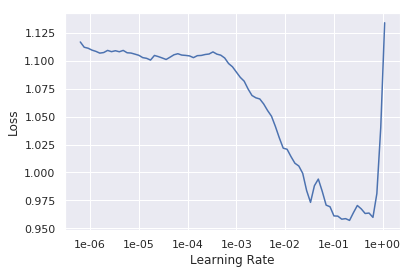

In [22]:
# find the optimal learning rate, just like before
learn.lr_find()

# graph it
learn.recorder.plot()

In [23]:
# like we did before, we choose a learning rate before
# the minimum of the graph and use the 1cycle policy
learn.fit_one_cycle(5,1e-2,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.708978,0.571571,0.790212,00:06
1,0.683751,0.521530,0.790592,00:06
2,0.674825,0.517836,0.799317,00:07
3,0.624344,0.500137,0.798938,00:07
4,0.629576,0.490014,0.806525,00:07


Now, onto the gradual unfreezing!

In [24]:
# unfreeze next layer
learn.freeze_to(-2)

# train with next layer unfrozen, apply discriminative fine-tuning
learn.fit_one_cycle(3,slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.596647,0.481887,0.812595,00:08
1,0.579514,0.471907,0.802731,00:08
2,0.551806,0.465008,0.811836,00:07


In [25]:
# repeat the process
learn.freeze_to(-3)
learn.fit_one_cycle(3,slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.540589,0.451447,0.823596,00:14
1,0.526239,0.452390,0.821320,00:13
2,0.417204,0.438106,0.828528,00:12


In [26]:
# now unfreeze everything
learn.unfreeze()
learn.fit_one_cycle(3,slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.450030,0.454428,0.827011,00:18
1,0.353306,0.459165,0.834219,00:17
2,0.235857,0.503255,0.827769,00:17


Now that we've gone through the entire process of ULMFiT and understood what is going on, we can move onto the 'ULMFiT-results' notebook.